In [1]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
from math import sqrt
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/winke/opt/anaconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Netherlands

In [9]:
#Load in data
#Import csv and remove non-numerical variables
df = pd.read_csv('weekly_new.csv')
df = df.drop(['name', 'year', 'week', 'latitude', 'longitude', 'espg'] , axis=1)

df = df[['counts_week', 'country', 'dem_mean', 'cycle_length', 'lst_mean', 'pop_sum', 'dem_std', 'build_area', 'street_length_total', 
          'ndvi_mean', 'restaurants', 'dist_to_bikePOI', '3_way_int_count', 'bike_points', 'daily_shops', 'median_speed', 'business_shops',
           'traffic_signals', 'dist_to_edu', 'dist_to_train', 'streets_per_node_avg', 'circuity_avg', 'lc_entropy', 'bus_stops', 'dist_to_greenspace']]


country = df[df['country'] == 'USA']
# country = df

#Create dependent and independent variable
y = country.loc[:,'counts_week']
X = country.drop(['counts_week', 'country'], axis=1)

# # Normalize dependent variable
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
# y = pd.Series(data_scaled.ravel())

In [10]:
#Create traintestsplit for machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## Linear Regression (OLS)

In [83]:
#Add a constant to the data and run OLS regression
Xc = sm.add_constant(X)
Xc.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
model = sm.OLS(y, Xc).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            counts_week   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     14.13
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           3.13e-35
Time:                        18:06:56   Log-Likelihood:                -2956.7
No. Observations:                 316   AIC:                             5961.
Df Residuals:                     292   BIC:                             6052.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2456.9859 

In [42]:
Xnc = Xc.drop('const', axis=1)

#Check multicolinearity with VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(Xnc.values, i) for i in range(Xnc.shape[1])]
vif["features"] = Xnc.columns

print(vif)

           VIF              features
0     2.624600              dem_mean
1     8.720544          cycle_length
2    34.192850              lst_mean
3    12.055408               pop_sum
4     5.748487               dem_std
5    14.702116            build_area
6    19.905105   street_length_total
7    19.639855             ndvi_mean
8     3.922460           restaurants
9     2.673266       dist_to_bikePOI
10   14.205166       3_way_int_count
11    1.521604           bike_points
12    1.874873           daily_shops
13    8.485139          median_speed
14    3.113838        business_shops
15    3.200109       traffic_signals
16    2.887795           dist_to_edu
17    2.531964         dist_to_train
18  111.257057  streets_per_node_avg
19  106.428237          circuity_avg
20   54.357692            lc_entropy
21    2.165082             bus_stops
22    2.569428    dist_to_greenspace


## Random Forest

In [47]:
# Define the parameter grid to search
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25],
            'min_samples_split': [2, 5, 10]}

# Create the random forest model
rf = RandomForestRegressor()

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_rf = RandomForestRegressor(**best_params)

#Run the model on the test split of the data
model_rf.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

#Calculate model statistics and print them
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
f1 = f1_score(y_test, y_pred > 0.5)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("F1 score:", f1)

Best parameters:  {'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 100}
Best score:  -0.5071254338666897


NameError: name 'f1_score' is not defined

Select which shap graph you would like to see using commenting

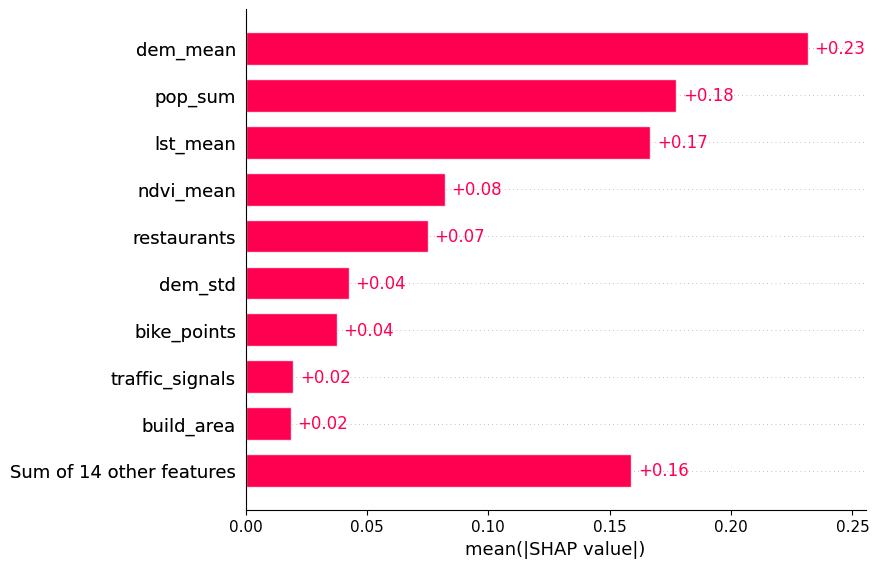

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


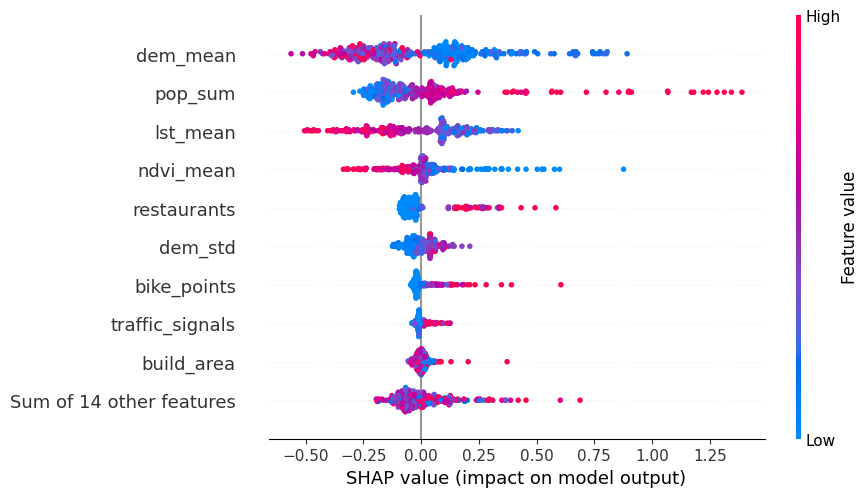

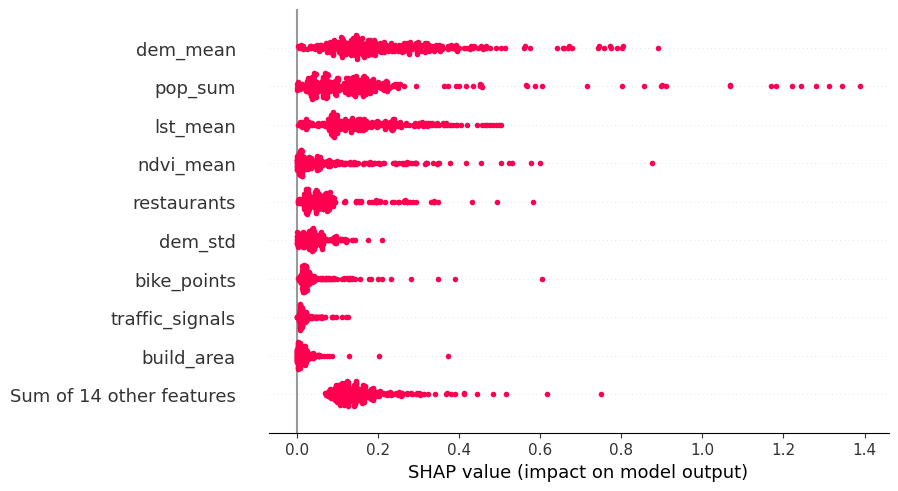

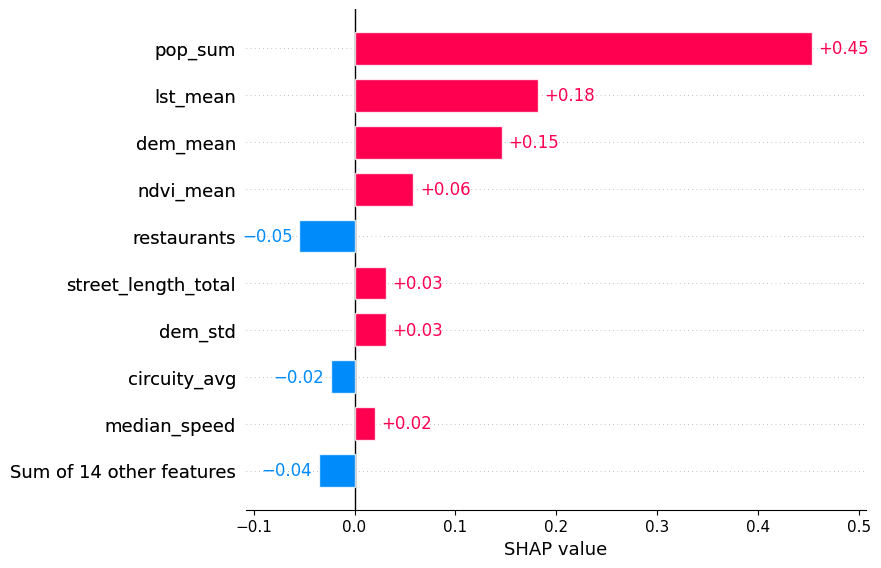

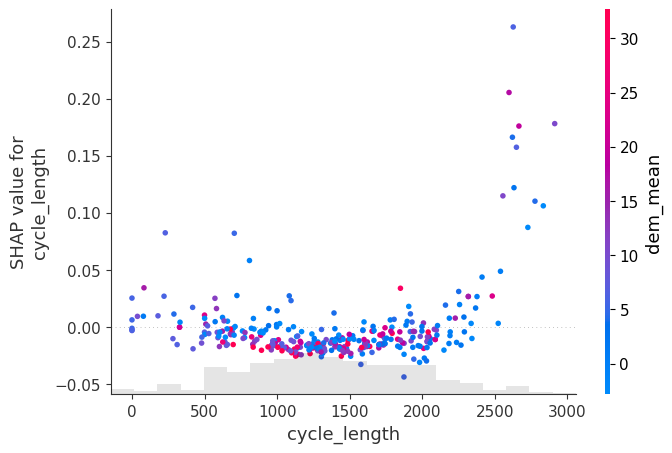

In [45]:
#Using SHAP to explain things
explainer = shap.Explainer(model_rf, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.bar(shap_values[1])

shap.plots.scatter(shap_values[:,"cycle_length"], color=shap_values)

## XGBoost

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search
param_grid = {'n_estimators': [50, 100, 200, 250, 300],
              'max_depth': [3, 5, 10, 15],
              'learning_rate': [0.1, 0.3, 0.5, 1],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.8, 1]
              }

# Create the XGBoost model
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(xgb_reg,
                param_grid=param_grid,
                cv=kf,
                scoring='neg_mean_squared_error',
                verbose=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_xgb = xgb.XGBRegressor(**best_params)

# Get the predictions of the model on the test data
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

# Calculate the R-squared, RMSE, MSE and F1-score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
# f1 = f1_score(y_test, y_pred > 0.5)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
# print("F1 score: ", f1)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best parameters:  {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best score:  -42553575.705419764
R-squared:  0.5009997263804984
MSE:  5162251.598837205
RMSE:  2272.058889825967
MAE:  1912.6649904604312


In [12]:
paris = pd.read_csv("/Users/winke/Documents/University/Thesis/Predicting_cycling/models/Paris.csv")
paris = paris[['dem_mean', 'cycle_length', 'lst_mean', 'pop_sum', 'dem_std', 'build_area', 'street_length_total', 
          'ndvi_mean', 'restaurants', 'dist_to_bikePOI', '3_way_int_count', 'bike_points', 'daily_shops', 'median_speed', 'business_shops',
           'traffic_signals', 'dist_to_edu', 'dist_to_train', 'streets_per_node_avg', 'circuity_avg', 'lc_entropy', 'bus_stops', 'dist_to_greenspace']]

paris.values

array([[5.93561644e+01, 2.34949827e+03, 2.06731369e+01, 2.84604907e+03,
        4.45383175e+00, 5.21650190e-02, 5.96573400e+03, 2.52676690e-01,
        1.90000000e+01, 5.00000000e+00, 2.60000000e+01, 1.70000000e+01,
        6.00000000e+00, 3.00000000e+01, 1.00000000e+01, 1.30000000e+01,
        0.00000000e+00, 6.30000000e+01, 3.29268293e+00, 1.02853885e+00,
        7.07555504e-01, 1.30000000e+01, 5.70000000e+01],
       [3.56100917e+01, 5.24102161e+02, 1.96089696e+01, 2.26256250e+03,
        6.25668736e+00, 8.17303480e-02, 4.78196300e+03, 2.29259399e-01,
        1.00000000e+01, 0.00000000e+00, 2.60000000e+01, 1.40000000e+01,
        1.00000000e+00, 3.00000000e+01, 1.00000000e+00, 8.00000000e+00,
        9.00000000e+00, 5.30000000e+01, 3.42105263e+00, 1.00911364e+00,
        8.57890339e-01, 2.00000000e+00, 2.80000000e+01],
       [3.58394495e+01, 1.17831174e+03, 2.04432608e+01, 1.30660913e+03,
        7.04291587e+00, 3.48513200e-02, 6.49107000e+03, 7.47256440e-02,
        0.00000000e+00

In [13]:
# Use the XGBoost model to make predictions on the new dataset
y_new_pred = model_xgb.predict(paris.values)

# Print the predictions
print(y_new_pred)

[ 4582.491   4899.5825  1638.6318 19603.781  16965.883  18022.055
   800.79    1614.3826  2915.0308 16336.258 ]


Select which shap graph you would like to see using commenting

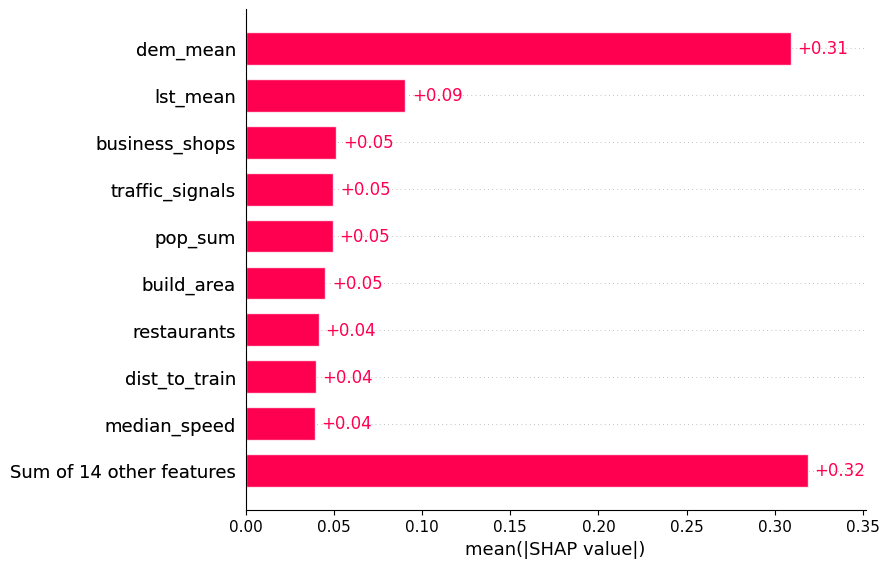

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


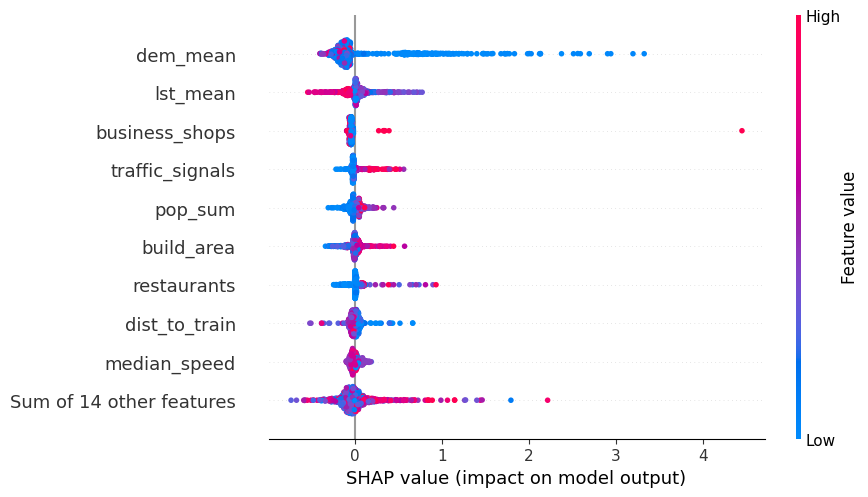

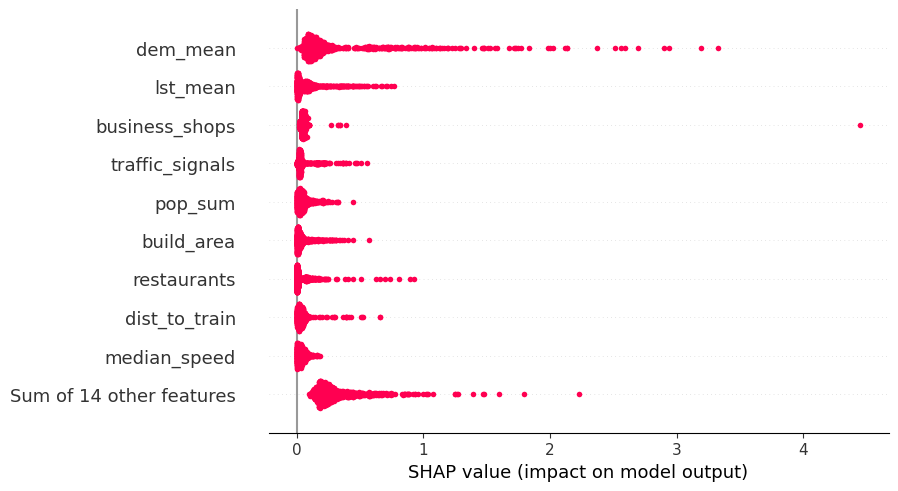

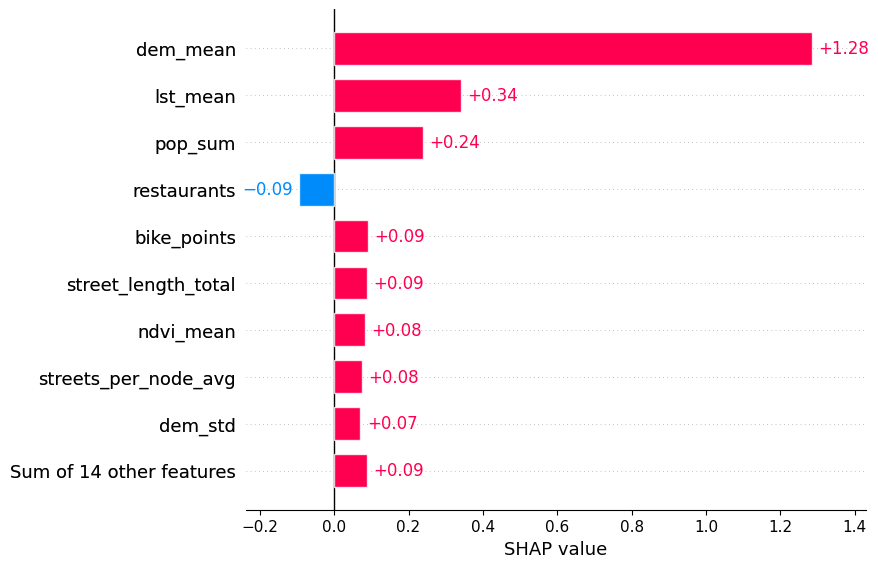

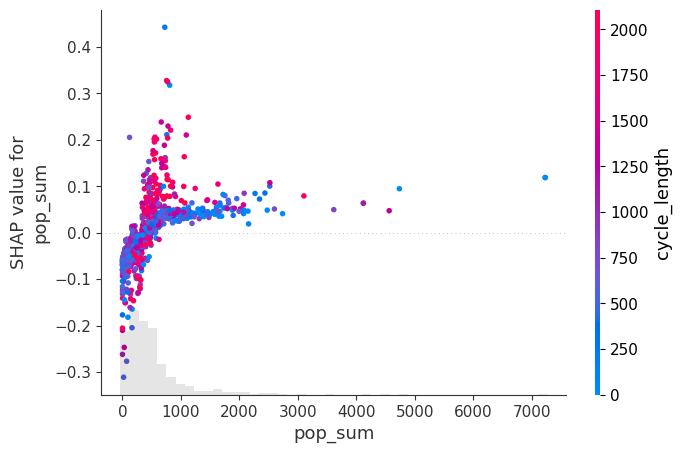

In [17]:
#Using SHAP to explain things
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.bar(shap_values[1])

shap.plots.scatter(shap_values[:,"pop_sum"], color=shap_values)

## SVM

In [4]:
# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel': ['linear', 'rbf']
              }

# Create the SVM model
svm_reg = SVR()

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(svm_reg,
                param_grid=param_grid,
                cv=kf,
                scoring='neg_mean_squared_error',
                verbose=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_svm = SVR(**best_params)

# Get the predictions of the model on the test data
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

# Calculate the R-squared, RMSE, MSE and F1-score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best score:  -0.9712348109386959
R-squared:  -0.0042942099096265895
MSE:  1.3042174197267484
RMSE:  1.142023388432456
MAE:  0.7475635605212967


Select which shap graph you would like to see using commenting

In [ ]:
#Using SHAP to explain things
explainer = shap.Explainer(model_svm, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.bar(shap_values[1])

shap.plots.scatter(shap_values[:,"ndvi_mean"], color=shap_values)